# Fluid Flow Simulation

Adapted from [the tutorial of FwiFlow.jl package](https://lidongzh.github.io/FwiFlow.jl/dev/tutorials/flow/), Coupled Time-Lapse Full-Waveform Inversion for Subsurface Flow Problems Using Intrusive Automatic Differentiation
Dongzhuo Li, Kailai Xu, Jerry M. Harris, Eric Darve

Thanks for the help on Docker image set-up from Thomas J. Grady II

# Set-up

### First, we set up some functions and structures below for fluid simulation, relative permeability, and fluid flow simulation.

In [1]:
const K_CONST =  9.869232667160130e-16 * 86400 * 1e3
const ALPHA = 1.0
const SRC_CONST = 86400.0 #
const GRAV_CONST = 9.8    # gravity constant

mutable struct Ctx
  m; n; h; NT; Δt; Z; X; ρw; ρo;
  μw; μo; K; g; ϕ; qw; qo; sw0
end

function tfCtxGen(m,n,h,NT,Δt,Z,X,ρw,ρo,μw,μo,K,g,ϕ,qw,qo,sw0,ifTrue)
  tf_h = constant(h)
  # tf_NT = constant(NT)
  tf_Δt = constant(Δt)
  tf_Z = constant(Z)
  tf_X= constant(X)
  tf_ρw = constant(ρw)
  tf_ρo = constant(ρo)
  tf_μw = constant(μw)
  tf_μo = constant(μo)
  # tf_K = isa(K,Array) ? Variable(K) : K
  if ifTrue
    tf_K = constant(K)
  else
    tf_K = Variable(K)
  end
  tf_g = constant(g)
  # tf_ϕ = Variable(ϕ)
  tf_ϕ = constant(ϕ)
  tf_qw = constant(qw)
  tf_qo = constant(qo)
  tf_sw0 = constant(sw0)
  return Ctx(m,n,tf_h,NT,tf_Δt,tf_Z,tf_X,tf_ρw,tf_ρo,tf_μw,tf_μo,tf_K,tf_g,tf_ϕ,tf_qw,tf_qo,tf_sw0)
end

function Krw(Sw)
    return Sw ^ 1.5
end

function Kro(So)
    return So ^1.5
end

function ave_normal(quantity, m, n)
    aa = sum(quantity)
    return aa/(m*n)
end

ave_normal (generic function with 1 method)

In [2]:
# variables : sw, u, v, p
# (time dependent) parameters: qw, qo, ϕ
function onestep(sw, p, m, n, h, Δt, Z, ρw, ρo, μw, μo, K, g, ϕ, qw, qo)
    # step 1: update p
    # λw = Krw(sw)/μw
    # λo = Kro(1-sw)/μo
    λw = sw.*sw/μw
    λo = (1-sw).*(1-sw)/μo
    λ = λw + λo
    q = qw + qo + λw/(λo+1e-16).*qo
    # q = qw + qo
    potential_c = (ρw - ρo)*g .* Z

    # Step 1: implicit potential
    Θ = upwlap_op(K * K_CONST, λo, potential_c, h, constant(0.0))

    load_normal = (Θ+q/ALPHA) - ave_normal(Θ+q/ALPHA, m, n)

    # p = poisson_op(λ.*K* K_CONST, load_normal, h, constant(0.0), constant(1))
    p = upwps_op(K * K_CONST, λ, load_normal, p, h, constant(0.0), constant(0)) # potential p = pw - ρw*g*h 

    # step 2: implicit transport
    sw = sat_op(sw, p, K * K_CONST, ϕ, qw, qo, μw, μo, sw, Δt, h)
    return sw, p
end


function imseq(tf_ctx)
    ta_sw, ta_p = TensorArray(tf_ctx.NT+1), TensorArray(tf_ctx.NT+1)
    ta_sw = write(ta_sw, 1, tf_ctx.sw0)
    ta_p = write(ta_p, 1, constant(zeros(tf_ctx.m, tf_ctx.n)))
    i = constant(1, dtype=Int32)
    function condition(i, tas...)
        i <= tf_ctx.NT
    end
    function body(i, tas...)
        ta_sw, ta_p = tas
        sw, p = onestep(read(ta_sw, i), read(ta_p, i), tf_ctx.m, tf_ctx.n, tf_ctx.h, tf_ctx.Δt, tf_ctx.Z, tf_ctx.ρw, tf_ctx.ρo, tf_ctx.μw, tf_ctx.μo, tf_ctx.K, tf_ctx.g, tf_ctx.ϕ, tf_ctx.qw[i], tf_ctx.qo[i])
        ta_sw = write(ta_sw, i+1, sw)
        ta_p = write(ta_p, i+1, p)
        i+1, ta_sw, ta_p
    end

    _, ta_sw, ta_p = while_loop(condition, body, [i, ta_sw, ta_p])
    out_sw, out_p = stack(ta_sw), stack(ta_p)
end

imseq (generic function with 1 method)

### Below is the main flow function -- taking permeability, porosity, injection, production, and simulation grid as inputs

In [3]:
function flow(K, ϕ, qw, qo, grid;
        ρw=501.9, ρo=1053.0, μw=0.1, μo=1.0, g=GRAV_CONST, S0=nothing)
    if isnothing(S0)
        S0 = zeros(grid.n[2], grid.n[1])
    end
    qw = permutedims(qw, [1, 3, 2]) * (1/grid.h^2)/grid.hy * SRC_CONST
    qo = permutedims(qo, [1, 3, 2]) * (1/grid.h^2)/grid.hy * SRC_CONST
    K = K'
    ϕ = ϕ'
    X = reshape(repeat((1:n[1])*grid.h, outer = n[2]), n[1], n[2])'
    Z = reshape(repeat((1:n[2])*grid.h, outer = n[1]), n[2], n[1])
    tfCtxTrue = tfCtxGen(grid.n[2],grid.n[1],grid.h,grid.nt,grid.dt,Z,X,ρw,ρo,μw,μo,K,g,ϕ,qw,qo,S0,true)
    sp = imseq(tfCtxTrue)
    sess = Session(); init(sess)
    S, p = run(sess, sp)
    return permutedims(S, [1, 3, 2]), permutedims(p, [1, 3, 2])
end

flow (generic function with 1 method)

## Main script

The main script is here! We start by loading the Julia packages. The main simulation is done in FwiFlow

In [4]:
using FwiFlow
using PyCall
using LinearAlgebra
using PyPlot

┌ Warning: Cannot load /Users/francisyin/.julia/packages/ADCME/94vEM/deps/CustomOps/build/libadcme.dylib. Please recompile the shared library by `ADCME.precompile()` for using custom operators.
└ @ ADCME /Users/francisyin/.julia/packages/ADCME/94vEM/src/ADCME.jl:78


### Next, let's set up the flow simulation parameters, i.e. the information of reservoir, injection etc.

In [5]:
# Hyperparameter for flow simulation
n = (30, 15)    # domain of simulation (number of cells in x * number of cells in z)
h = 30.0        # size of the cell (in meter)
hy= 10.0        # width of the cell in y direction (now it's 2D code but CO2 lives in 3D space!)
nt = 50         # number of time steps
dt = 20         # time interval between 2 adjacent time steps (in day), you should NOT set this large otherwise the solver will be unstable

mutable struct comp_grid       # set up the grid structure
   n  :: Tuple{Integer, Integer} # x, z
   h  :: Float64 # meter
   hy :: Float64 # meter
   nt :: Integer 
   dt :: Number  # day
end

grid_ = comp_grid(n, h, hy, nt, dt)


comp_grid((30, 15), 30.0, 10.0, 50, 20)

### Then let's set up the well information. In this software, there is assumed to be injection well(s) for CO2 injection and production well(s) for water production.

In [6]:
qw = zeros(nt, n[1], n[2]);
inj_loc = (3*h, 9*h);    # injection location (at (3,9) cell in this case)
qw[:,Int(round(inj_loc[1]/h)), Int(round(inj_loc[2]/h))] .= 0.005;   # in [m^3/s]

qo = zeros(nt, n[1], n[2]);
prod_loc = (28*h, 9*h);  # injection location (at (28,9) cell in this case)
qo[:,Int(round(prod_loc[1]/h)),Int(round(prod_loc[2]/h))] .= -0.005; # also in [m^3/s]

### Then let's set up the permeability and porosity.

In [7]:
ϕ = 0.25 .* ones(n); # porosity [0-1]
K = 20.0 .* ones(n); # permeability [millidarcy]
K[:,8:10] .= 120.0;  # set a high permeability channel in the middle

### We can plot the permeability model and porosity model using PyPlot package. Its usage is quite similar to matplotlib in python (actually it's based on that)

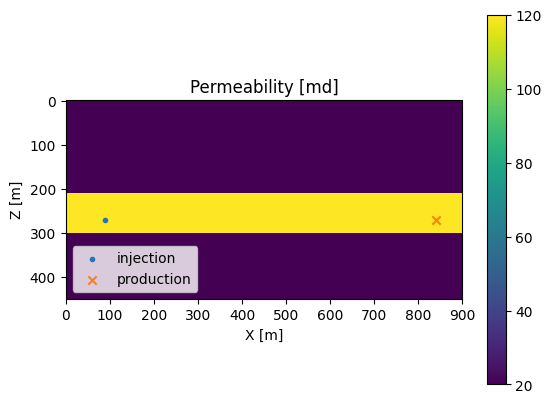

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/francisyin/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [8]:
figure();imshow(K',extent=(0,n[1]*h,n[2]*h,0));title("Permeability [md]");
xlabel("X [m]");ylabel("Z [m]");
colorbar();
scatter(inj_loc[1], inj_loc[2], marker=".", label="injection")
scatter(prod_loc[1], prod_loc[2], marker="x", label="production")
legend(loc=3);

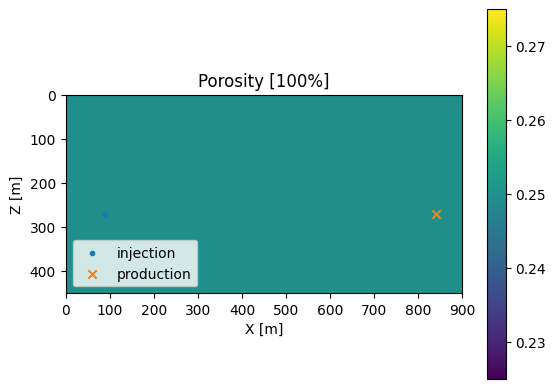

In [9]:
figure();imshow(ϕ',extent=(0,n[1]*h,n[2]*h,0));title("Porosity [100%]");
xlabel("X [m]");ylabel("Z [m]");
colorbar();
scatter(inj_loc[1], inj_loc[2], marker=".", label="injection")
scatter(prod_loc[1], prod_loc[2], marker="x", label="production")
legend(loc=3);

### Now let's run the flow simulation in 1 line!

In [10]:
S, p = flow(K, ϕ, qw, qo, grid_);

Load library operator (with gradient, multiple outputs = false): /Users/francisyin/.julia/packages/FwiFlow/4kyhS/deps/CustomOps/Upwlap/build/libUpwlapOp.dylib ==> upwlap_op
Load library operator (with gradient, multiple outputs = false): /Users/francisyin/.julia/packages/FwiFlow/4kyhS/deps/CustomOps/Upwps/build/libUpwpsOp.dylib ==> upwps_op
Load library operator (with gradient, multiple outputs = false): /Users/francisyin/.julia/packages/FwiFlow/4kyhS/deps/CustomOps/Saturation/build/libSatOp.dylib ==> sat_op


2022-02-03 11:08:40.343352: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-02-03 11:08:40.369226: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbea7857140 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-02-03 11:08:40.369239: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


### And then let's take a look at the CO2 saturation at various time steps.

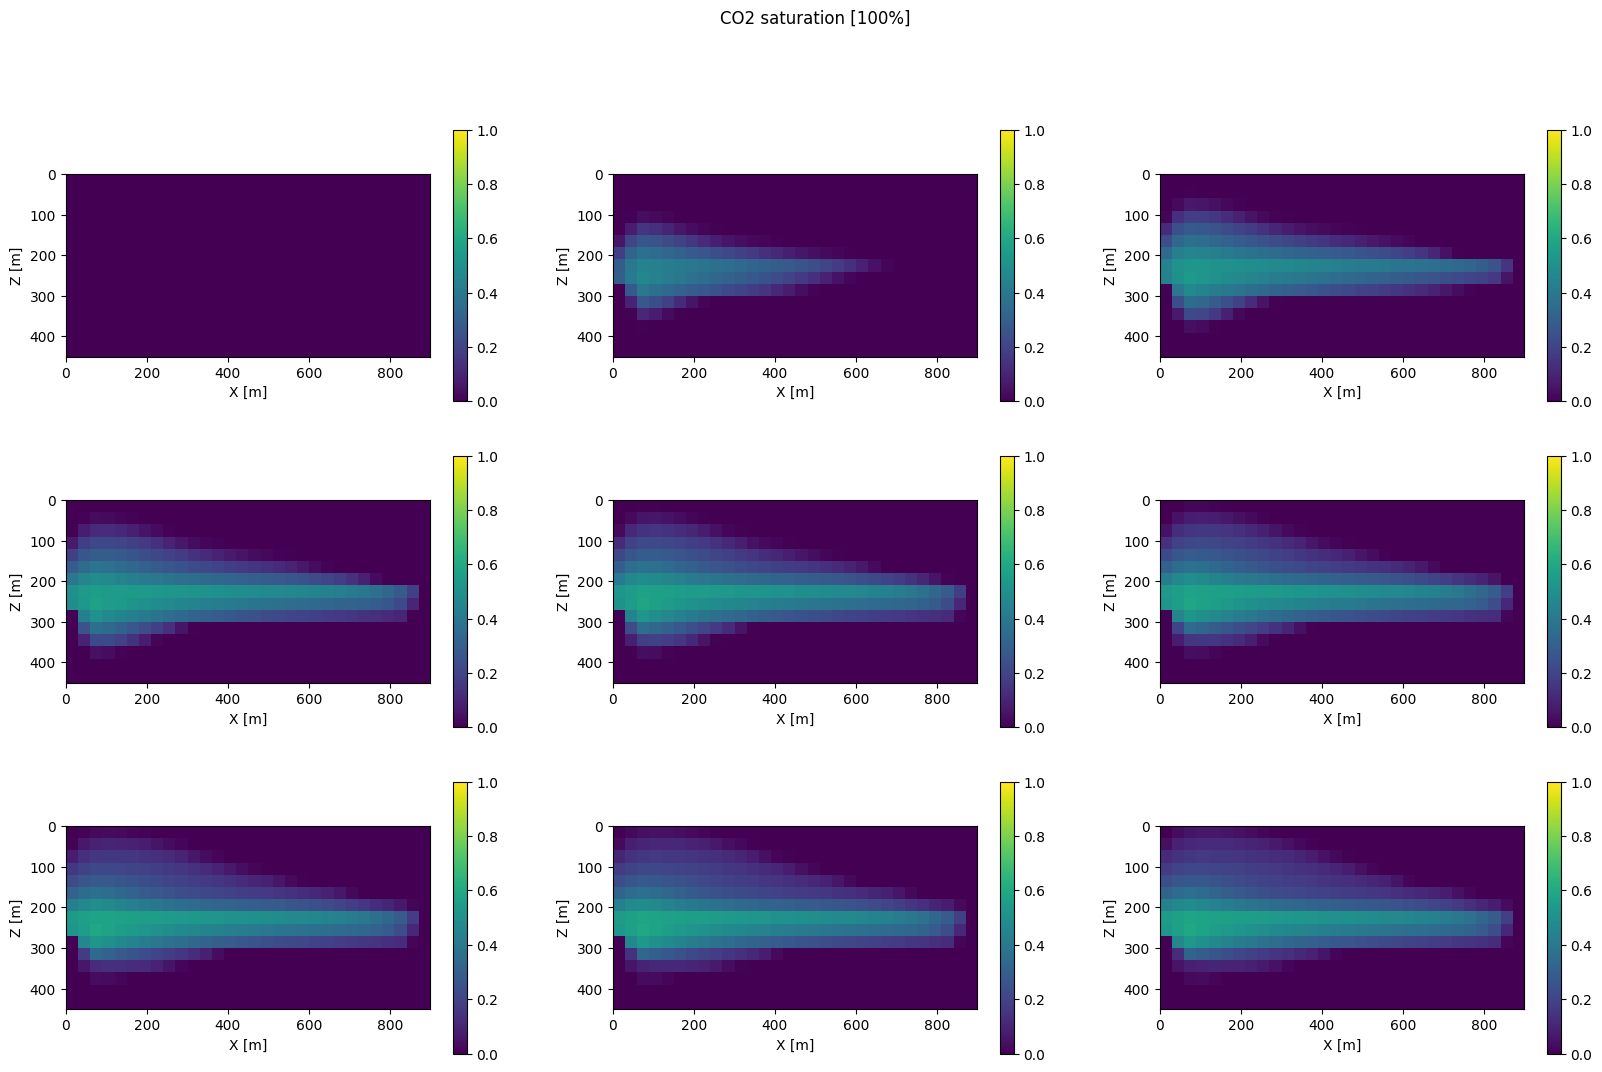

PyObject Text(0.5, 0.98, 'CO2 saturation [100%]')

In [11]:
figure(figsize=(20,12));
obs = Int.(round.(range(1, stop=nt+1, length=9)));   # 9 observed time samples
for i = 1:9
    subplot(3,3,i)
    imshow(S[obs[i], :, :]', extent=(0,n[1]*h,n[2]*h,0), vmin=0, vmax=1)
    xlabel("X [m]");ylabel("Z [m]");
    colorbar()
end
suptitle("CO2 saturation [100%]")

# TO-DO:

## Q1
1. What do you see in these time-varying CO2 saturation images? How do you interpret the movement of CO2?
2. Calculate the amount of CO2 in the reservoir after 60 days of injection. Is it the same as the injection amount? (If not, why?)
3. Calculate the capacity coefficient after 90 days of injection.
4. Calculate the amount of CO2 in the reservoir at the end of injection. Is it the same as the injection amount? (If not, why?)

## Q2
1. Re-run this experiment with a homogeneous permeability model, i.e. remove the yellow high permeability channel in the middle. Plot the CO2 saturations with correct labels and colorbars. Compare them with the saturations with the high permeability channel. What do you see? How do you interpret the result?

## Q3
1. Re-run this experiment with the high permeability channel, but without the production well, i.e. make it 0. Plot the CO2 saturations with correct labels and colorbars. What do you see? How do you interpret the result?